In [13]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from ipywidgets import interact, IntSlider, fixed
from IPython.display import display
from PIL import Image
from skimage.transform import resize
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
cudnn.benchmark = True
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import json
import torch
from torchvision.models import resnet50
from torch.nn.functional import softmax
from PIL import Image
from torchvision import transforms
from morphology import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE

# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

model = nn.DataParallel(model)

import tensorflow as tf

img_path = 'catdog.png'
img = read_tensor(img_path)
img_insertion = read_tensor(img_path)

def predict_with_resnet50_pytorch(image_tensor, target_class=243):
    # Ensure the model is in evaluation mode
    model = resnet50(pretrained=True)
    model = model.eval()

    # Ensure the tensor is in the correct shape [C, H, W] with C=3, H=W=224
    # Check for batch dimension and add if missing
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        percentage = probabilities[0][target_class].item() * 100
        top_probabilities, top_classes = torch.topk(probabilities, k=3)
    # Convert output probabilities to softmax probabilities

    # Decode predictions to find the top 3 predictions
    return f'Prediction for class {target_class} = {percentage:.2f}%', top_probabilities[0], top_classes[0]

predicted_classes, top_probabilities, top_classes = predict_with_resnet50_pytorch(img)

# Assuming get_class_name is a function to get class names from class indices
# You'll need to define or import this function
print(predicted_classes)
for i in range(len(top_classes)):
    class_name = get_class_name(top_classes[i].item())
    percentage = top_probabilities[i].item() * 100
    print(f'Top {i+1} class: {class_name}, Probability: {percentage:.2f}%')

print(predicted_classes)
get_class_name(top_classes[0].item())
target_class = top_classes[0].item()
print(get_class_name(target_class))

Prediction for class 243 = 38.42%
Top 1 class: bull mastiff, Probability: 38.42%
Top 2 class: tiger cat, Probability: 16.83%
Top 3 class: boxer, Probability: 9.41%
Prediction for class 243 = 38.42%
bull mastiff


In [14]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models import resnet50
from skimage.transform import resize
from tqdm import tqdm
from morphology import Dilation2d, Erosion2d

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def generate_support_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        support_masks = np.empty((N, *self.input_size))

        for i in range(N):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            support_masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                            anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        support_masks = support_masks.reshape(-1, 1, *self.input_size)
        support_masks = torch.from_numpy(support_masks).float().cuda()
        return support_masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class, get_class_name):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        target_class_name = get_class_name(243)

        print(f'Target class: {target_class_name}')
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            top_pred_class = probabilities.argmax(dim=1).item()

        print(f'Initial top predicted class: {get_class_name(top_pred_class)}')

        sampled_tensor = torch.empty((N, *img_tensor.shape), device=img_tensor.device)
        scores = torch.empty(N, device=img_tensor.device)
        self.generate_masks(N, s, p1)

        dilation = Dilation2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        erosion = Erosion2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)

        for i in range(N):
            if i % 2 == 0:
                tag = "Pass"
            else:
                tag = "Fail"
            print(f'Mutant {i}, tag={tag}')

            found = False
            mask = self.masks[i].clone()
            kernel_size=5
            erosion_count = 0
            dilation_count = 0
            iteration_count = 0

            while not found:  # Limit the number of iterations
                masked_image = torch.mul(mask, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    top_probabilities, top_classes = torch.topk(probabilities, k=3, dim=1)
                    top_pred_class = top_classes[0][0].item()
                    top_pred_class_name = get_class_name(top_pred_class)

                print(f'tag={tag}, top_pred_class_name={top_pred_class_name}, target_class_name={target_class_name}')

                if (tag == "Pass" and top_pred_class_name == target_class_name) or (tag == "Fail" and top_pred_class_name != target_class_name):
                    print('Mutant found')
                    found = True
                    best_mutant = masked_image
                    sampled_tensor[i] = best_mutant[-1].squeeze(0)
                    scores[i] = probabilities[:, target_class].max().item() * 100
                    self.masks[i] = mask[-1]
                else:
                    if tag == "Pass" and top_pred_class_name != target_class_name:
                        mask = dilation(mask)
                        print('Mutant Pass, but the image is too covered. Applying dilation.')
                        kernel_size += 5
                        dilation_count += 1
                        if dilation_count >= 8:
                            print('Dilation limit reached, generating new support mask.')
                            new_mask = self.generate_support_masks(1, s, p1)
                            kernel_size = 5
                            mask = new_mask
                            dilation_count = 0
                    elif tag == "Fail" and top_pred_class_name == target_class_name:
                        mask = erosion(mask)
                        print('Mutant Fail, but the image is too clear. Applying erosion.')
                        kernel_size += 5
                        erosion_count += 1
                        if erosion_count >= 8:
                            print('Erosion limit reached, generating new support mask.')
                            new_mask = self.generate_support_masks(1, s, p1)
                            erosion_count = 0
                            mask = new_mask
                            kernel_size = 5
        masks = self.masks
        return masks, sampled_tensor, scores.cpu().tolist()

# Usage example
def get_class_name(class_idx):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[class_idx].split(',')[0].split()[1:])

model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))
N = 20
masks, sampled_tensor, scores = explainer.generate_mutants(img, N, s=5, p1=0.1, target_class=target_class, get_class_name=get_class_name)


Target class: bull mastiff
Initial top predicted class: bull mastiff


Generating filters: 100%|██████████| 20/20 [00:00<00:00, 784.16it/s]

Mutant 0, tag=Pass
tag=Pass, top_pred_class_name=lighter, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=lighter, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=lighter, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=quill, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=quill, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=quill, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=quill, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=quill, target_class_name=bull masti

tag=Pass, top_pred_class_name=tiger cat, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=tiger cat, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=tiger cat, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
Dilation limit reached, generating new support mask.
tag=Pass, top_pred_class_name=bull mastiff, target_class_name=bull mastiff
Mutant found
Mutant 1, tag=Fail
tag=Fail, top_pred_class_name=Pekinese, target_class_name=bull mastiff
Mutant found
Mutant 2, tag=Pass
tag=Pass, top_pred_class_name=tiger cat, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=tiger cat, target_class_name=bull mastiff
Mutant Pass, but the image is too covered. Applying dilation.
tag=Pass, top_pred_class_name=tiger cat, target_class_name=bull mas

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed
import torch  # Assuming the mutants tensor is a PyTorch tensor

def visualize_single_mutant(mutants, scores, index):
    """
    Visualize a single mutant image with its score.

    Parameters:
    - mutants: Tensor of mutant images.
    - scores: List or array of scores corresponding to the mutant images.
    - index: Index of the mutant image to visualize.
    """
    mutant_image = mutants[index].detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Squeeze and permute dimensions
    plt.figure(figsize=(5, 5))
    plt.imshow(mutant_image)
    plt.title(f"Mutant {index+1}\n{scores[index]:.2f}%")
    plt.axis('off')
    plt.show()

# Example tensor and scores (replace these with your actual data)
num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant,
         mutants=fixed(sampled_tensor),
         scores=fixed(scores),
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

         # Convert scores to a PyTorch tensor
scores_tensor = torch.tensor(scores, dtype=torch.float32)

# Perform the division
scores_tensor = scores_tensor / 100

# Convert the tensor back to a list
scores_list = scores_tensor.tolist()

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=19), Output()), _dom_classes=('widge…

In [16]:
def is_within_range(tensor):
    """
    Checks if all values in the tensor are between 0 and 1 inclusive.

    Args:
        tensor (torch.Tensor): Input tensor.

    Returns:
        bool: True if all values are between 0 and 1, False otherwise.
    """
    return torch.all((tensor >= 0) & (tensor <= 1)).item()


def calculate_relevance_scores(sampled_tensor, mask, N, scores, device='cuda'):

    sampled_tensor = sampled_tensor.to(device)
    scores = torch.tensor(scores, device=device)
    _, C, H, W = sampled_tensor.shape
    scores_reshaped = scores.view(-1, 1, 1, 1)
    DX = N / 2

    new_shape = [N] * N

# Create a new tensor with the required shape, where each dimension is filled with its respective value
    #scores_expanded = scores.view(-1, *([1] * (N - 1))).expand(new_shape)
    pass_indices = torch.arange(N, device=device) % 2 == 0
    fail_indices = torch.arange(N, device=device) % 2 != 0
    shape = (N, 1, 224, 224)

    tensor_ones = torch.ones(shape).to(device)
    reverse_mask = tensor_ones - mask
    executed_tensors = tensor_ones * mask
    not_executed_tensors = tensor_ones * reverse_mask

    e_pass_tensors = executed_tensors[pass_indices] 
    e_fail_tensors = executed_tensors[fail_indices] 

    n_pass_tensors = not_executed_tensors[pass_indices] 
    n_fail_tensors = not_executed_tensors[fail_indices] 


    Ep = e_pass_tensors.sum(dim=0)
    Ef = e_fail_tensors.sum(dim=0)
    Np = n_pass_tensors.sum(dim=0)
    Nf = n_fail_tensors.sum(dim=0)

    return Ep, Ef, Np, Nf

def calculate_ochiai(Ep, Np, Ef, Nf):
    return Ef / torch.sqrt((Ef + Nf) * (Ef + Ep))

def calculate_tarantula(Ep, Np, Ef, Nf):
    return (Ef / (Ef + Nf)) / ((Ef / (Ef + Nf)) + (Ep / (Ep + Np)))

def calculate_zoltar(Ep, Np, Ef, Nf):
    return Ef / (Ef + Nf + Ep + ((10000 * Nf * Ep) / Ef))

def calculate_wong1(Ep, Np, Ef, Nf):
    return Ef - Ep

def map_values_to_range(values, target_min=0, target_max=100):
    src_min = values.min()
    src_max = values.max()
    return target_min + (values - src_min) * (target_max - target_min) / (src_max - src_min)

# Assuming img, masks, N, scores, and threshold are defined
Ep, Ef, Np, Nf = calculate_relevance_scores(img, masks, N, scores_list)

# Calculate scores directly on tensors
ochiai_scores = calculate_ochiai(Ep, Np, Ef, Nf)
tarantula_scores = calculate_tarantula(Ep, Np, Ef, Nf)
zoltar_scores = calculate_zoltar(Ep, Np, Ef, Nf)
wong1_scores = calculate_wong1(Ep, Np, Ef, Nf)

# Map values to range if necessary
mapped_ochiai_scores = map_values_to_range(ochiai_scores)
mapped_tarantula_scores = map_values_to_range(tarantula_scores)
mapped_zoltar_scores = map_values_to_range(zoltar_scores)
mapped_wong1_scores = map_values_to_range(wong1_scores)


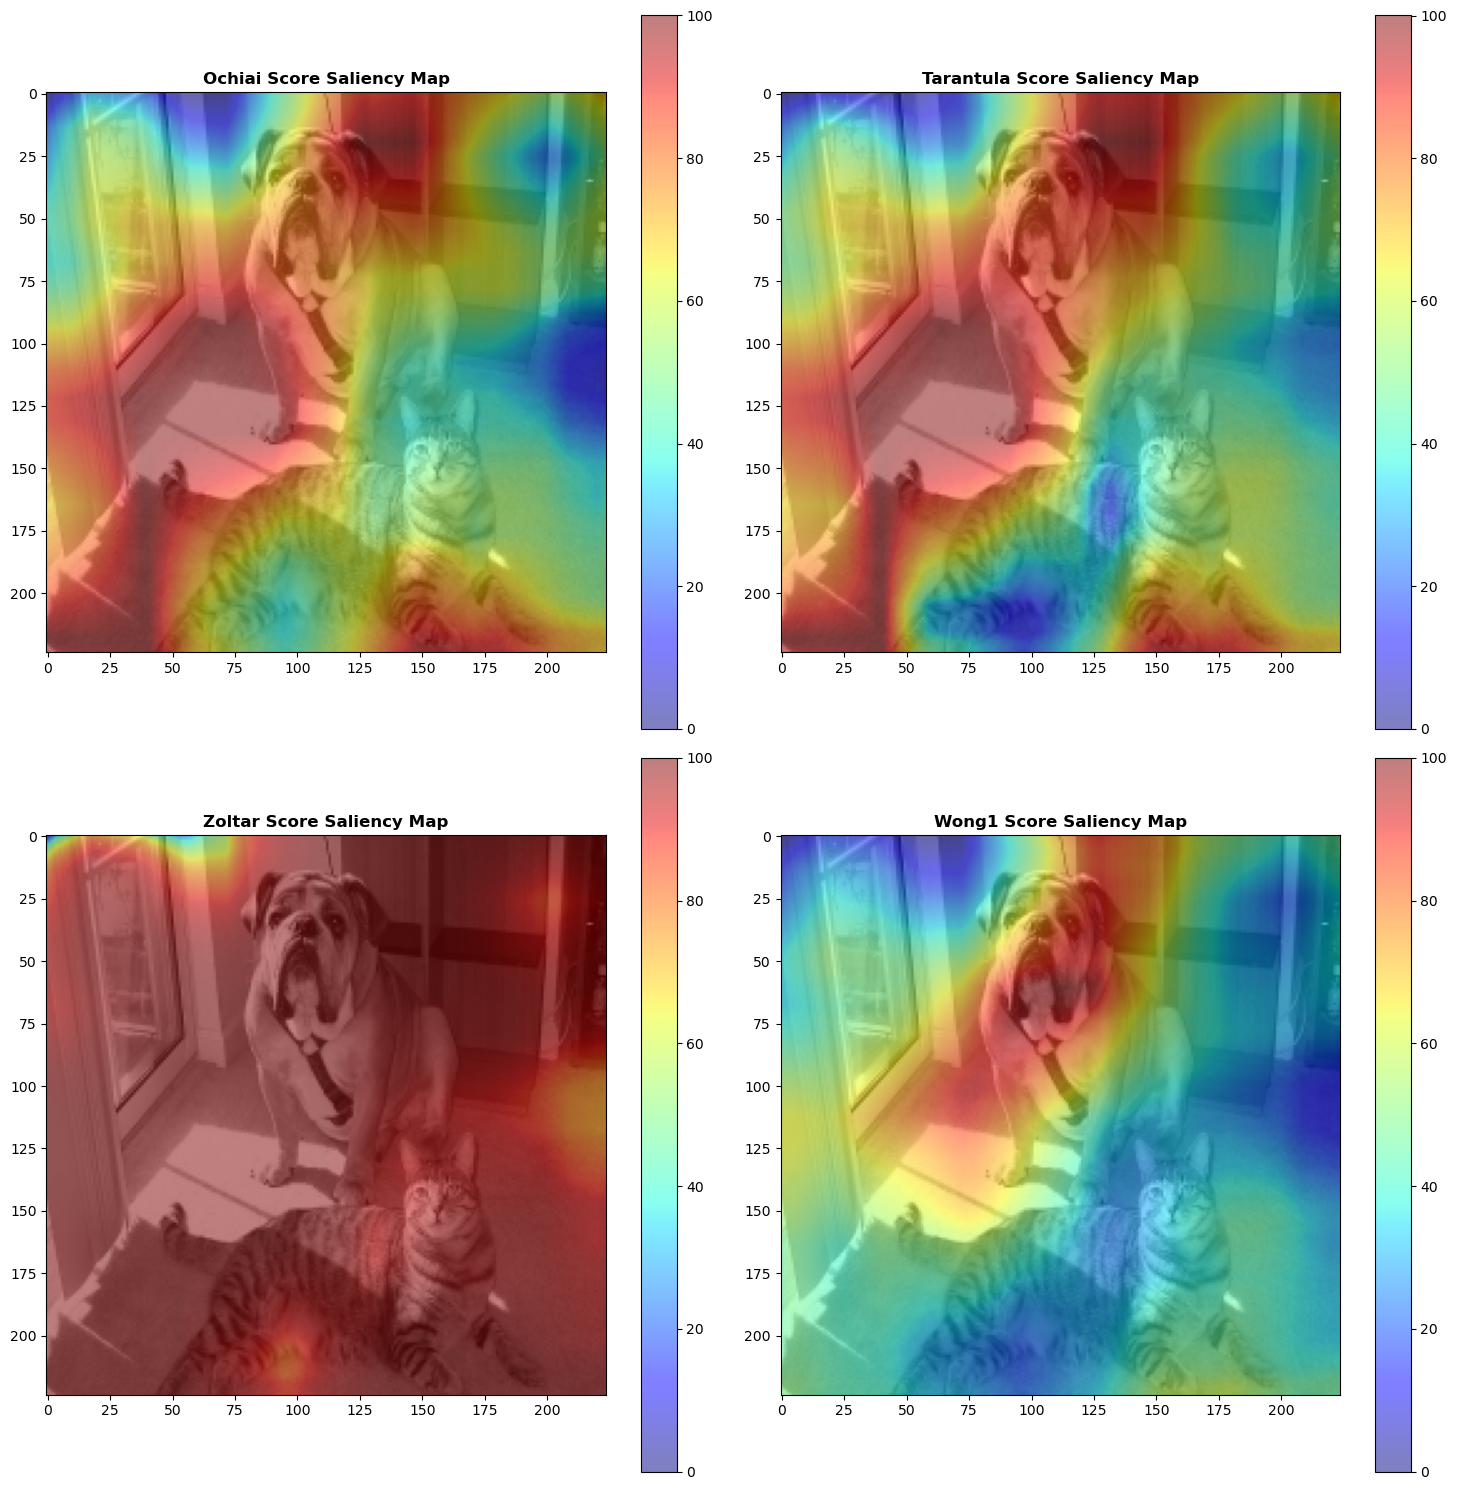

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Convert to numpy arrays by moving tensors to CPU first
mapped_ochiai_scores_np = mapped_ochiai_scores.cpu().detach().numpy()
mapped_tarantula_scores_np = mapped_tarantula_scores.cpu().detach().numpy()
mapped_zoltar_scores_np = mapped_zoltar_scores.cpu().detach().numpy()
mapped_wong1_scores_np = mapped_wong1_scores.cpu().detach().numpy()

original_image_array = np.array(original_image)

# Prepare the saliency maps
ochiai_map = mapped_ochiai_scores_np.reshape((224, 224))
tarantula_map = mapped_tarantula_scores_np.reshape((224, 224))
zoltar_map = mapped_zoltar_scores_np.reshape((224, 224))
wong1_map = mapped_wong1_scores_np.reshape((224, 224))

ochiai_map = ochiai_map.max() - ochiai_map
tarantula_map = tarantula_map.max() - tarantula_map
zoltar_map = zoltar_map.max() - zoltar_map
wong1_map = wong1_map.max() - wong1_map

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Define the extent
extent = [0, 224, 0, 224]

# List of maps and titles
maps = [ochiai_map, tarantula_map, zoltar_map, wong1_map]
titles = ['Ochiai Score Saliency Map', 'Tarantula Score Saliency Map', 'Zoltar Score Saliency Map', 'Wong1 Score Saliency Map']

ochiai_map.shape
# Plot each map
for ax, saliency_map, title in zip(axs.ravel(), maps, titles):
    # Display the original image
    ax.imshow(original_image_array, cmap='gray')

    # Overlay the saliency map
    c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

    # Add a colorbar
    fig.colorbar(c, ax=ax)

    # Add title
    ax.set_title(title, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()



Performing Deletion: 100%|██████████| 224/224 [00:01<00:00, 142.93it/s]


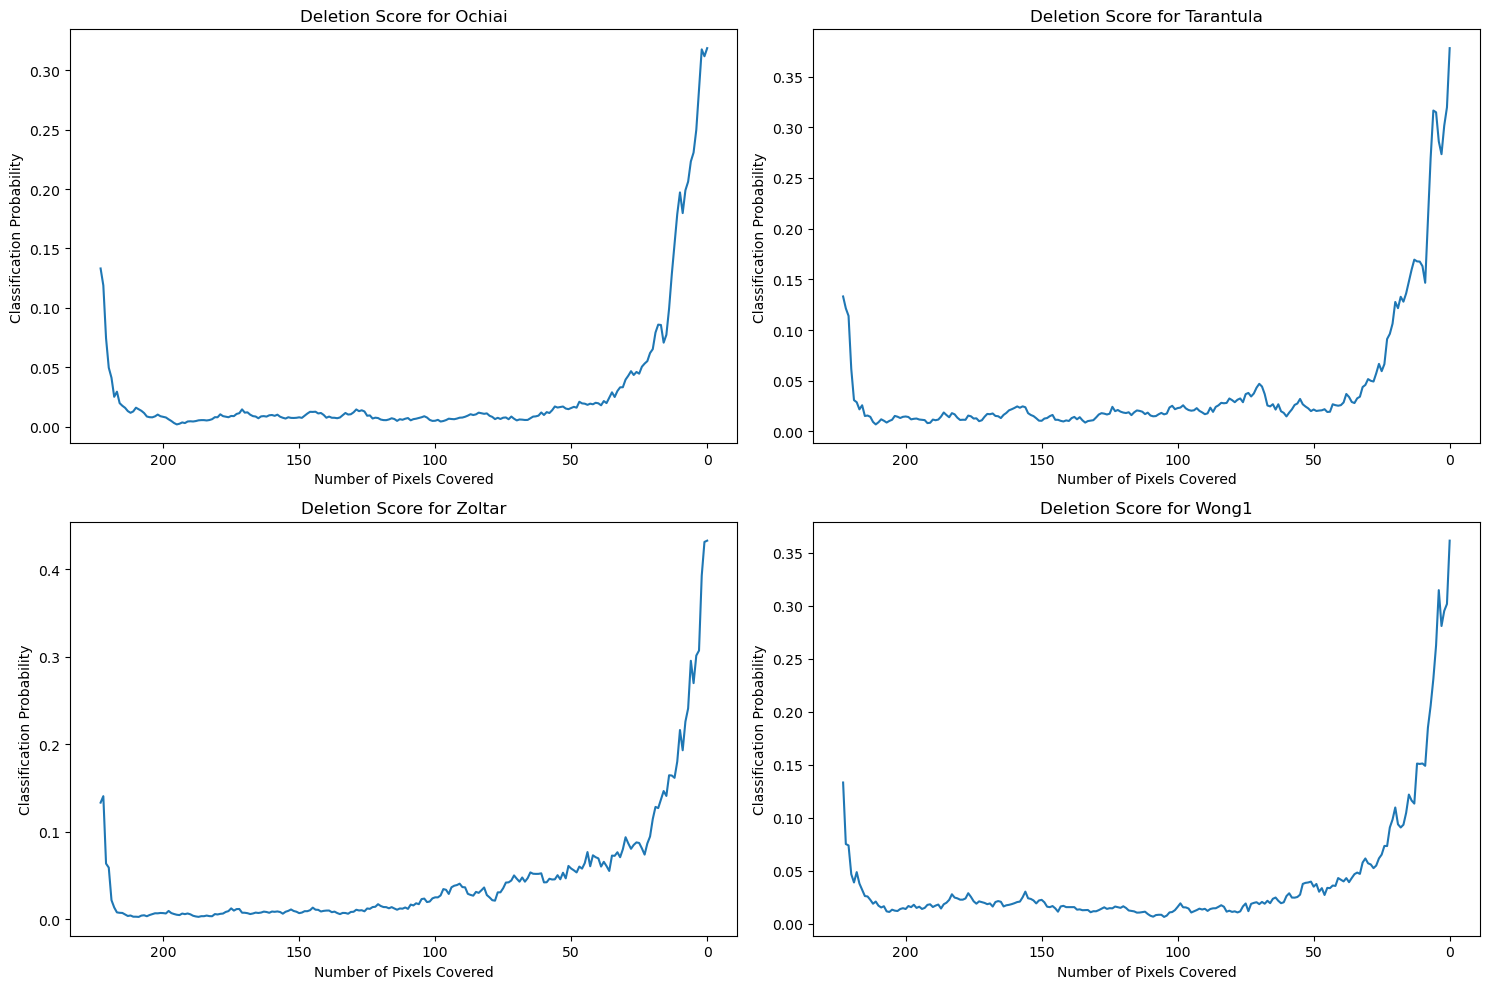

In [18]:

def get_importance_ranks(saliency_map):
    # Flatten the saliency map and get the sorted indices
    flat_saliency = saliency_map.flatten()
    ranks = np.argsort(-flat_saliency)  # Sort in descending order of importance
    return ranks

def perform_deletion(image_tensor, importance_ranks, step_size=224):
    h = []
    mask = torch.ones_like(image_tensor).cuda()
    image_tensor = image_tensor.cuda()
    # Convert importance ranks to 3D indices
    importance_ranks = [(r // (224 * 224), (r % (224 * 224)) // 224, r % 224) for r in importance_ranks]
    
    for i in tqdm(range(0, len(importance_ranks), step_size), desc="Performing Deletion"):
        # Cover next step_size pixels
        for j in range(step_size):
            if i + j < len(importance_ranks):
                c_idx, h_idx, w_idx = importance_ranks[i + j]
                mask[:, c_idx, h_idx, w_idx] = 0

        masked_image = image_tensor * mask
        
        # Perform inference
        with torch.no_grad():
            output = model(masked_image)
            probabilities = F.softmax(output, dim=1)
            h.append(probabilities[:, target_class].item())
    
    return h

# Generate saliency maps (simulated here; replace with actual saliency maps)
saliency_maps = {
    'ochiai': np.random.rand(224, 224),
    'tarantula': np.random.rand(224, 224),
    'zoltar': np.random.rand(224, 224),
    'wong1': np.random.rand(224, 224),
}

# Define the target class (for example purposes, we'll use class index 243)
target_class = 243

# Calculate deletion scores for each saliency map
deletion_scores = {}
for method, saliency_map in saliency_maps.items():
    importance_ranks = get_importance_ranks(saliency_map)
    deletion_scores[method] = perform_deletion(img_insertion,  importance_ranks)

# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
methods = list(deletion_scores.keys())

for ax, method in zip(axs.ravel(), methods):
    d = deletion_scores[method]
    ax.plot(d)
    ax.set_title(f'Deletion Score for {method.capitalize()}')
    ax.set_xlabel('Number of Pixels Covered')
    ax.set_ylabel('Classification Probability')
    ax.invert_xaxis()

plt.tight_layout()
plt.show()